            +------------+     +---------------+     +-----------+
            | user_data  |     | post_text_df  |     | feed_data |
            +------------+     +---------------+     +-----------+
            | age        |     | id            |     | timestamp |
            | city       |     | text          |     | user_id   |
            | country    |     | topic         |     | post_id   |
            | exp_group  |     +---------------+     | action    |
            | gender     |           7,023           | target    |
            | id         |                           +-----------+
            | os         |                             76,892,800
            | source     |
            +------------+
                163,205 

# Data Preprocessing

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

# Чтение данных таблицы user_data
query = "SELECT * FROM user_data"
user_data = pd.read_sql(query, engine)

# Чтение данных таблицы post_text_df
query = "SELECT * FROM post_text_df"
post_text_df = pd.read_sql(query, engine)

# Чтение ограниченного количества данных таблицы feed_data
query = "SELECT * FROM feed_data LIMIT 100000"
feed_data = pd.read_sql(query, engine)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle


In [4]:
# Переименование столбцов идентификаторов
user_data = user_data.rename(columns={'id': 'user_id'})
post_text_df = post_text_df.rename(columns={'id': 'post_id'})

# Объединение таблиц
data = feed_data.merge(user_data, on='user_id', how='left')
data = data.merge(post_text_df, on='post_id', how='left')


In [5]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-10-19 09:44:37,42876,6282,like,0,0,15,Russia,Abakan,1,Android,ads,Little Dieter Needs To Fly is another in the r...,movie
1,2021-10-19 09:44:39,42876,4588,view,0,0,15,Russia,Abakan,1,Android,ads,I bought the DVD of Before Sunset and saw it f...,movie
2,2021-10-19 09:46:38,42876,545,view,0,0,15,Russia,Abakan,1,Android,ads,Oceans Twelve raids box office\n\nOceans Twelv...,entertainment
3,2021-10-19 09:47:20,42876,4006,view,0,0,15,Russia,Abakan,1,Android,ads,@CPHO_Canada @JustinTrudeau #CoronaVirus #CoVi...,covid
4,2021-10-19 09:48:23,42876,3534,view,0,0,15,Russia,Abakan,1,Android,ads,@bbclaurak He understood very well on 3rd Feb ...,covid


# Ferauture engineering

### Time
Here we will create 3 new feautures from the timestamp:
1. hour_of_day
2. time_since_last_action
3. day_of_week

In [6]:
import pandas as pd

# Convert the timestamp format to a datetime object
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Extract features from the timestamp
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['hour_of_day'] = data['timestamp'].dt.hour

# Calculate the time since the last action for each user
data = data.sort_values(['user_id', 'timestamp'])
data['time_since_last_action'] = data.groupby('user_id')['timestamp'].diff().dt.total_seconds()
data['time_since_last_action'].fillna(0, inplace=True)


In [7]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic,day_of_week,hour_of_day,time_since_last_action
1259,2021-11-11 08:21:43,1928,5996,view,0,0,18,Russia,Sarapul,3,iOS,ads,What ever happened to shows with united parent...,movie,3,8,0.0
1260,2021-11-11 08:23:10,1928,7315,view,0,0,18,Russia,Sarapul,3,iOS,ads,"OK, I would not normally watch a Farrelly brot...",movie,3,8,87.0
1261,2021-11-11 08:24:43,1928,6051,view,0,0,18,Russia,Sarapul,3,iOS,ads,"On more than one level, I can relate to what h...",movie,3,8,93.0
1262,2021-11-11 08:25:40,1928,2677,view,0,0,18,Russia,Sarapul,3,iOS,ads,Two most dangerous viruses that the world is f...,covid,3,8,57.0
1263,2021-11-11 08:27:44,1928,2975,view,0,0,18,Russia,Sarapul,3,iOS,ads,It was reported that a witness said he heard t...,covid,3,8,124.0


### One hot encoding

In [8]:
# One-hot encoding for 'country', 'city', and 'topic'
data = pd.get_dummies(data, columns=['country', 'city', 'topic'], prefix=['country', 'city', 'topic'])

In [9]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,exp_group,os,source,...,city_Zheleznogorsk,city_Zlatoust,city_Zyryanovsk,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
1259,2021-11-11 08:21:43,1928,5996,view,0,0,18,3,iOS,ads,...,0,0,0,0,0,0,1,0,0,0
1260,2021-11-11 08:23:10,1928,7315,view,0,0,18,3,iOS,ads,...,0,0,0,0,0,0,1,0,0,0
1261,2021-11-11 08:24:43,1928,6051,view,0,0,18,3,iOS,ads,...,0,0,0,0,0,0,1,0,0,0
1262,2021-11-11 08:25:40,1928,2677,view,0,0,18,3,iOS,ads,...,0,0,0,0,1,0,0,0,0,0
1263,2021-11-11 08:27:44,1928,2975,view,0,0,18,3,iOS,ads,...,0,0,0,0,1,0,0,0,0,0


### Label encoding

In [10]:
from sklearn.preprocessing import LabelEncoder

le_gender = LabelEncoder()
le_os = LabelEncoder()
le_source = LabelEncoder()
le_action = LabelEncoder()

# Label encoding for 'gender', 'os', and 'source'
data['gender'] = le_gender.fit_transform(data['gender'])
data['os'] = le_os.fit_transform(data['os'])
data['source'] = le_source.fit_transform(data['source'])
data['action'] = le_action.fit_transform(data['action'])


In [11]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,exp_group,os,source,...,city_Zheleznogorsk,city_Zlatoust,city_Zyryanovsk,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
1259,2021-11-11 08:21:43,1928,5996,1,0,0,18,3,1,0,...,0,0,0,0,0,0,1,0,0,0
1260,2021-11-11 08:23:10,1928,7315,1,0,0,18,3,1,0,...,0,0,0,0,0,0,1,0,0,0
1261,2021-11-11 08:24:43,1928,6051,1,0,0,18,3,1,0,...,0,0,0,0,0,0,1,0,0,0
1262,2021-11-11 08:25:40,1928,2677,1,0,0,18,3,1,0,...,0,0,0,0,1,0,0,0,0,0
1263,2021-11-11 08:27:44,1928,2975,1,0,0,18,3,1,0,...,0,0,0,0,1,0,0,0,0,0


In [12]:
# check data type of each column
print(data.dtypes)

timestamp              datetime64[ns]
user_id                         int64
post_id                         int64
action                          int32
target                          int64
                            ...      
topic_entertainment             uint8
topic_movie                     uint8
topic_politics                  uint8
topic_sport                     uint8
topic_tech                      uint8
Length: 172, dtype: object


идеи для создания новых признаков:

1. Количество просмотров и лайков для каждого пользователя.
2. Количество просмотров и лайков для каждого поста.
3. Среднее время между просмотрами для каждого пользователя.
4. Доля лайков от просмотров для каждого пользователя и поста.
5. Количество просмотров и лайков для каждой темы.
6. Количество просмотров и лайков для каждой операционной системы и источника трафика.
7. Доля просмотров и лайков для каждой темы от общего числа просмотров и лайков пользователя.

### Количество просмотров и лайков для каждого пользователя, os, source, topic

In [13]:
# Feature 1: Количество просмотров и лайков для каждого пользователя
user_views_likes = data.groupby('user_id')['action'].value_counts().unstack().fillna(0)
user_views_likes.columns = ['user_views', 'user_likes']
data = data.merge(user_views_likes, on='user_id', how='left')

# Feature 2: Количество просмотров и лайков для каждого поста
post_views_likes = data.groupby('post_id')['action'].value_counts().unstack().fillna(0)
post_views_likes.columns = ['post_views', 'post_likes']
data = data.merge(post_views_likes, on='post_id', how='left')


In [14]:
temp_df = data[['exp_group', 'topic_business', 'topic_covid', 'topic_entertainment', 'topic_movie', 'topic_politics', 'topic_sport', 'topic_tech', 'action']]
for col in ['topic_business', 'topic_covid', 'topic_entertainment', 'topic_movie', 'topic_politics', 'topic_sport', 'topic_tech']:
    temp_df[col] = temp_df[col] * temp_df['action']
grouped_data = temp_df.groupby('exp_group').sum().reset_index()
grouped_data.columns = ['exp_group'] + [f'{col}_exp_group_views' if i % 2 == 0 else f'{col}_exp_group_likes' for i, col in enumerate(grouped_data.columns[1:], 1)]
data = data.merge(grouped_data, on='exp_group', how='left')


C:\Users\Alex\AppData\Local\Temp\ipykernel_48980\2710859347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[col] = temp_df[col] * temp_df['action']


In [15]:
# print the list of columns
print(data.columns.tolist())

['timestamp', 'user_id', 'post_id', 'action', 'target', 'gender', 'age', 'exp_group', 'os', 'source', 'text', 'day_of_week', 'hour_of_day', 'time_since_last_action', 'country_Azerbaijan', 'country_Belarus', 'country_Finland', 'country_Kazakhstan', 'country_Latvia', 'country_Russia', 'country_Turkey', 'country_Ukraine', 'city_Abakan', 'city_Baku', 'city_Balashikha', 'city_Baranavichy', 'city_Barnaul', 'city_Belebey', 'city_Belgorod', 'city_Belorechensk', 'city_Berdsk', 'city_Blagoveshchensk', 'city_Borovichi', 'city_Bryansk', 'city_Chelyabinsk', 'city_Chita', 'city_Chusovoy', 'city_Dnipro', 'city_Dolgoprudnyy', 'city_Donetsk', 'city_Dubna', 'city_Dzerzhinsk', 'city_Grayvoron', 'city_Groznyy', 'city_Gukovo', 'city_Gulkevichi', 'city_Horad Barysaw', 'city_Ipatovo', 'city_Irkutsk', 'city_Istanbul', 'city_Ivano-Frankivsk', 'city_Jūrmala', 'city_Kaliningrad', 'city_Kamennogorsk', 'city_Kamyshin', 'city_Kamyshlov', 'city_Kansk', 'city_Kazan', 'city_Kemerovo', 'city_Khabarovsk', 'city_Kharkiv'

## Feauture selection

### Pearson's Correlation Coefficient
We will discard this method because it is not suitable for categorical features.

In [16]:
import pandas as pd
import numpy as np

# Assuming your data is in a DataFrame called 'data'
# and your target variable is in a column called 'target'

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Get the correlations between each feature and the target variable
target_correlations = correlation_matrix['target'].drop('target')

# Sort the correlations by their absolute values in descending order
sorted_correlations = target_correlations.abs().sort_values(ascending=False)

# Select the top k features with the highest absolute correlations
k = 50  # You can choose any number based on your requirements
top_k_features = sorted_correlations.head(k).index.tolist()

# Create a new DataFrame with the selected features
selected_data = data[top_k_features]

print("Top", k, "features:")
print(top_k_features)
print("\nSelected data:")
print(selected_data.head())


C:\Users\Alex\AppData\Local\Temp\ipykernel_48980\3439295280.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


Top 50 features:
['post_views', 'action', 'user_views', 'country_Russia', 'country_Belarus', 'city_Groznyy', 'post_likes', 'city_Moscow', 'country_Ukraine', 'time_since_last_action', 'city_Maladzyechna', 'city_Krasnodar', 'gender', 'city_Pokrovsk', 'city_Simferopol', 'city_Baranavichy', 'city_Dnipro', 'city_Ufa', 'city_Makhachkala', 'city_Berdsk', 'city_Tegul’det', 'city_Voskresensk', 'country_Finland', 'city_Slobodskoy', 'city_Kemerovo', 'hour_of_day', 'city_Polevskoy', 'city_Polatsk', 'city_Yekaterinburg', 'city_Nevel', 'city_Belorechensk', 'city_Chelyabinsk', 'city_Sharypovo', 'city_Donetsk', 'city_Konnevesi', 'city_Dzerzhinsk', 'city_Krasnyy Chikoy', 'city_Saint Petersburg', 'city_Sergiyev Posad', 'city_Nefteyugansk', 'city_Uzlovaya', 'city_Miass', 'topic_tech', 'city_Kaliningrad', 'city_Magnitogorsk', 'city_Rybnoye', 'city_Ipatovo', 'city_Grayvoron', 'city_Mariupol', 'city_Tyumen']

Selected data:
   post_views  action  user_views  country_Russia  country_Belarus  \
0         5.0 

C:\Users\Alex\AppData\Local\Temp\ipykernel_48980\1391933483.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


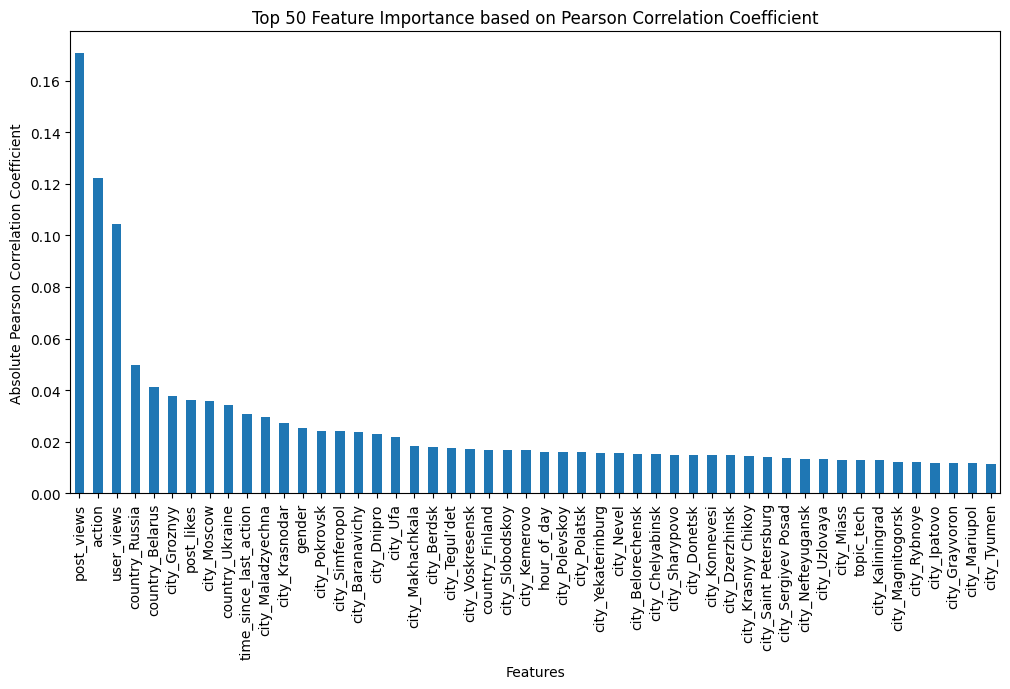

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_top_features(num_top_features):
    # Assuming your data is in a DataFrame called 'data'
    # and your target variable is in a column called 'target'

    # Calculate the correlation matrix
    correlation_matrix = data.corr()

    # Get the correlations between each feature and the target variable
    target_correlations = correlation_matrix['target'].drop('target')

    # Sort the correlations by their absolute values in descending order
    sorted_correlations = target_correlations.abs().sort_values(ascending=False)

    # Select the top features
    top_features = sorted_correlations.head(num_top_features)

    # Plot the feature importances
    plt.figure(figsize=(12, 6))
    top_features.plot(kind='bar')
    plt.xlabel('Features')
    plt.ylabel('Absolute Pearson Correlation Coefficient')
    plt.title(f'Top {num_top_features} Feature Importance based on Pearson Correlation Coefficient')
    plt.show()

# Call the function with the desired number of top features to display
plot_top_features(50)


### Mutual Information
We will choose this method because it is suitable for both categorical and numerical features.

In [18]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, SelectKBest

# Assume `data` is your DataFrame with features and target
X = data.drop(['target', 'timestamp', 'text'], axis=1)
y = data['target']

# Calculate mutual information between each feature and the target variable
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame with feature names and their corresponding MI scores
mi_scores_df = pd.DataFrame({'feature': X.columns, 'mi_score': mi_scores})

# Sort the DataFrame by MI scores in descending order
mi_scores_df = mi_scores_df.sort_values('mi_score', ascending=False)

# Optionally, select the top k features using SelectKBest
k = 30
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]

print("Top k features based on mutual information:")
print(selected_features)


Top k features based on mutual information:
Index(['user_id', 'action', 'gender', 'age', 'exp_group', 'os', 'source',
       'day_of_week', 'time_since_last_action', 'country_Russia',
       'city_Kamyshlov', 'city_Moscow', 'city_Polatsk', 'city_Simferopol',
       'city_Tegul’det', 'city_Vyborg', 'topic_covid', 'topic_movie',
       'user_views', 'user_likes', 'post_views', 'post_likes',
       'topic_business_exp_group_likes', 'topic_covid_exp_group_views',
       'topic_entertainment_exp_group_likes', 'topic_movie_exp_group_views',
       'topic_politics_exp_group_likes', 'topic_sport_exp_group_views',
       'topic_tech_exp_group_likes', 'action_exp_group_views'],
      dtype='object')


# Model engineering

## Data preprocessing

We will use only the following features that we selected (`selected_features`) using the mutual information method:
`
'user_id', 'action', 'gender', 'age', 'exp_group', 'os', 'source',
       'day_of_week', 'time_since_last_action', 'country_Russia',
       'city_Kamyshlov', 'city_Moscow', 'city_Polatsk', 'city_Simferopol',
       'city_Tegul’det', 'city_Vyborg', 'topic_covid', 'topic_movie',
       'user_views', 'user_likes', 'post_views', 'post_likes',
       'topic_business_exp_group_likes', 'topic_covid_exp_group_views',
       'topic_entertainment_exp_group_likes', 'topic_movie_exp_group_views',
       'topic_politics_exp_group_likes', 'topic_sport_exp_group_views',
       'topic_tech_exp_group_likes', 'action_exp_group_views'`

In [19]:
df_top_k = data[selected_features]

# split the data into train and test
from sklearn.model_selection import train_test_split

X = df_top_k
y = data['target']

# Splitting 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Data scaling

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##  Model selection

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Initialize the models
logreg = LogisticRegression(solver='liblinear', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(random_state=42)

# List of models for easy iteration
models = [logreg, rf, xgb]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']

# Perform cross-validation and print the average accuracy for each model
for name, model in zip(model_names, models):
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f'{name} average accuracy: {cv_scores.mean():.4f}')


Logistic Regression average accuracy: 0.8911
Random Forest average accuracy: 0.8825
XGBoost average accuracy: 0.8898


In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier

# Initialize the additional models
svm = SVC(kernel='linear', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

# Define the base models for stacking
base_models = [
    ('logreg', logreg),
    ('rf', rf),
    ('xgb', xgb),
    ('svm', svm),
    ('knn', knn)
]

# Initialize the meta-model (you can choose a different model if you like)
meta_model = LogisticRegression(solver='liblinear', random_state=42)

# Initialize the StackingClassifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Train and evaluate the stacking classifier using cross-validation
cv_scores_stacking = cross_val_score(stacking_clf, X_train, y_train, cv=5, scoring='accuracy')
print(f'Stacking Classifier average accuracy: {cv_scores_stacking.mean():.4f}')
